In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from skimage.feature import hog
from skimage.color import rgb2gray

In [2]:
# Paths to dataset directories
train_dir = "../Supervised/dataset/datasetsplitted/train"
val_dir = "../Supervised/dataset/datasetsplitted/val"
test_dir = "../Supervised/dataset/datasetsplitted/test"


In [3]:
# Parameters
IMG_SIZE = (64, 64)  # Image size
BATCH_SIZE = 32

# Load datasets
train_dataset = image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_dataset = image_dataset_from_directory(val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 2583 files belonging to 20 classes.
Found 323 files belonging to 20 classes.
Found 329 files belonging to 20 classes.


In [4]:
# Get class names and encode labels
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

label_encoder = LabelEncoder()
label_encoder.fit(class_names)

Found 20 classes: ['Golf', 'bmw serie 1', 'chevrolet spark', 'chevroulet aveo', 'clio', 'duster', 'hyundai i10', 'hyundai tucson', 'logan', 'megane', 'mercedes class a', 'nemo citroen', 'octavia', 'picanto', 'polo', 'sandero', 'seat ibiza', 'symbol', 'toyota corolla', 'volkswagen tiguan']


LabelEncoder()

In [5]:
# Function to extract HOG features
def extract_hog_features(dataset):
    features, labels = [], []
    for images, lbls in dataset:
        for img in images.numpy():
            gray_img = rgb2gray(img)  # Convert to grayscale
            hog_features = hog(gray_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            features.append(hog_features)
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

In [6]:
# Extract HOG features
X_train, y_train = extract_hog_features(train_dataset)
X_val, y_val = extract_hog_features(val_dataset)
X_test, y_test = extract_hog_features(test_dataset)

In [7]:
# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=7, criterion='gini', random_state=42, min_samples_leaf=2, max_leaf_nodes=10,
                                  min_samples_split=2)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=7, max_leaf_nodes=10, min_samples_leaf=2,
                       random_state=42)

In [8]:
# Evaluate on test set
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute the confusion matrix

Accuracy: 0.1580547112462006
                   precision    recall  f1-score   support

             Golf       0.00      0.00      0.00        16
      bmw serie 1       0.00      0.00      0.00         9
  chevrolet spark       0.00      0.00      0.00        11
  chevroulet aveo       0.00      0.00      0.00        13
             clio       0.17      0.29      0.21        35
           duster       0.47      0.32      0.38        28
      hyundai i10       0.00      0.00      0.00        13
   hyundai tucson       0.00      0.00      0.00        13
            logan       0.00      0.00      0.00        12
           megane       0.06      0.18      0.09        28
 mercedes class a       0.00      0.00      0.00         9
     nemo citroen       0.38      0.38      0.38         8
          octavia       0.09      0.56      0.15        16
          picanto       0.45      0.72      0.55        18
             polo       0.10      0.14      0.12        14
          sandero       0.

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

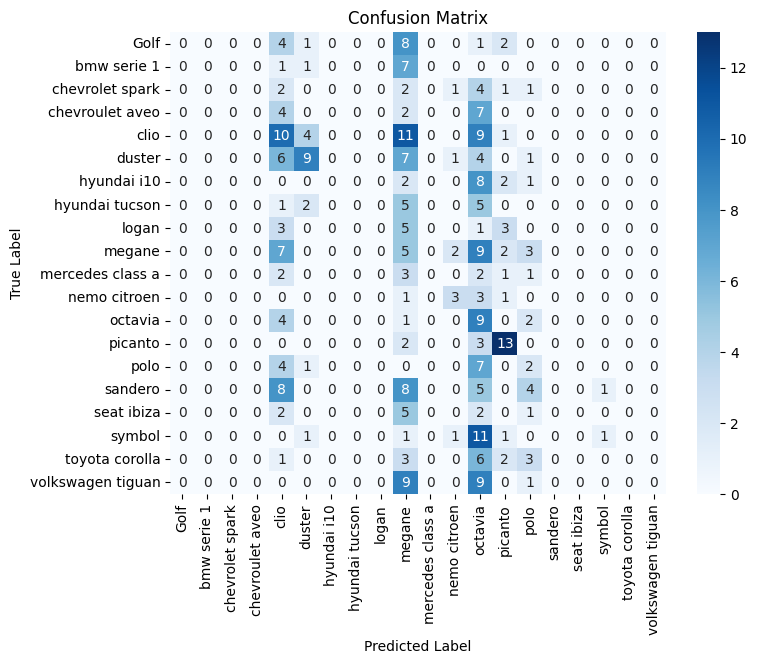

In [9]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [10]:

# Compute Hamming Distance
hamming_distance = np.mean(y_pred != y_test)
print(f"Hamming Distance: {hamming_distance}")

Hamming Distance: 0.8419452887537994


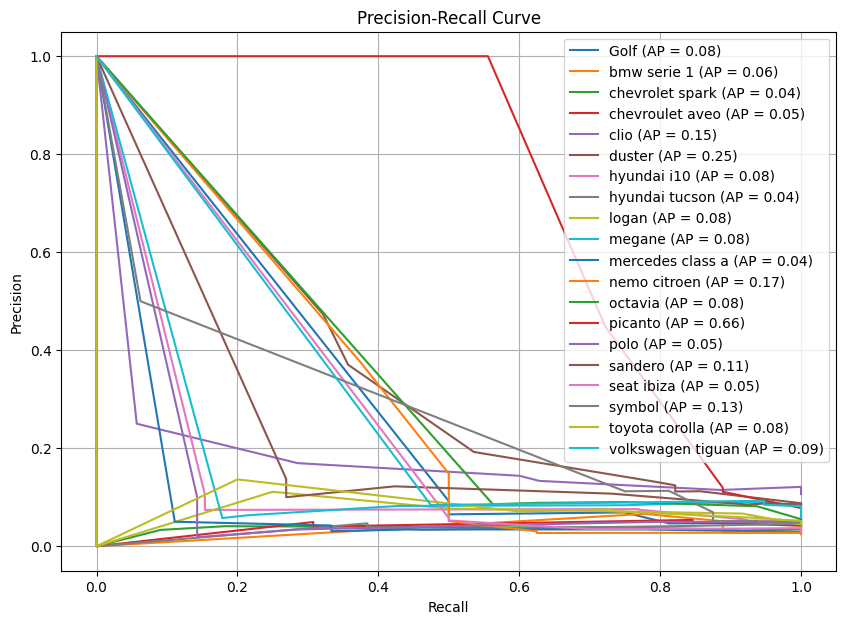

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision score for each class
precision = {}
recall = {}
average_precision = {}

for i in range(num_classes):
    y_test_bin = (y_test == i).astype(int)  # Convert to binary classification for each class
    y_pred_prob = dt_model.predict_proba(X_test)[:, i]  # Get predicted probabilities

    precision[i], recall[i], _ = precision_recall_curve(y_test_bin, y_pred_prob)
    average_precision[i] = average_precision_score(y_test_bin, y_pred_prob)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()
